In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.regularizers import l2, l1_l2

# Loading Data

In [ ]:
path ='/content/drive/MyDrive/NNDL Project'

In [ ]:
# Loading Data
X_test = np.load(path + "/X_test.npy")
y_test = np.load(path + "/y_test.npy")
person_train_valid = np.load(path + "/person_train_valid.npy")
X_train_valid = np.load(path + "/X_train_valid.npy")
y_train_valid = np.load(path + "/y_train_valid.npy")
p_test = np.load(path + "/person_test.npy")

In [ ]:
# Shape of Data
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(p_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# Splitting Data into Train and Validation Sets

In [ ]:
# Generating the training and validation indices using random splitting
ind_valid = np.random.choice(X_train_valid.shape[0], math.floor(0.2*X_train_valid.shape[0]), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
(p_train, p_valid) = person_train_valid[ind_train], person_train_valid[ind_valid]

In [ ]:
# Shape of train and valid Data

print ('Train data shape: {}'.format(X_train.shape))
print ('Valid data shape: {}'.format(X_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))

print ('Train target shape: {}'.format(y_train.shape))
print ('Train valid shape: {}'.format(y_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

print ('Person train shape: {}'.format(p_train.shape))
print ('Person valid shape: {}'.format(p_valid.shape))
print ('Person test shape: {}'.format(p_test.shape))

Train data shape: (1692, 22, 1000)
Valid data shape: (423, 22, 1000)
Test data shape: (443, 22, 1000)
Train target shape: (1692,)
Train valid shape: (423,)
Test target shape: (443,)
Person train shape: (1692, 1)
Person valid shape: (423, 1)
Person test shape: (443, 1)


# Data Pre-processing and Augmentation

In [ ]:
def train_data_prep(X,y,p,sub_sample=2,average=2,noise=True):

    # Adjusting labels
    y -= 769

    total_X = None
    total_y = None
    total_p = None

    # Cropping the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data in time dimension (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    total_p = p
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging original data + adding noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Augmenting averaged data with noise to max pool filtered data
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.vstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + optionally adding noise
    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        # augmenting subsampled plus optionally noise added data
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.vstack((total_p, p))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    print('Shape of P:',total_p.shape)

    return total_X, total_y, total_p


def test_data_prep(X, y, p, sub_sample=2):

    #Adjusting labels
    total_y = y - 769
    total_p = p
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X, total_y, total_p

In [ ]:
# Preprocessing the dataset
print('Train Prep:')
X_train, y_train, p_train = train_data_prep(X_train, y_train, p_train)
print()
print('Validation Prep:')
X_valid, y_valid, p_valid = train_data_prep(X_valid, y_valid, p_valid)
print()
print('Test Prep:')
X_test, y_test, p_test = test_data_prep(X_test, y_test, p_test)

Train Prep:
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of P: (6768, 1)

Validation Prep:
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of X after averaging+noise and concatenating: (846, 22, 400)
Shape of X after subsampling and concatenating: (1692, 22, 400)
Shape of Y: (1692,)
Shape of P: (1692, 1)

Test Prep:
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)


In [ ]:
# Confirming labels look good - should be between 0 and 3
print(y_train[0])
print(y_valid[0])
print(y_test[0])

2
3
1


In [ ]:
print('Shape of all data after preprocessing')
print()

print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)
print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)
print()

print("Test Data Shape: ")
print("Input Shape:", X_test.shape)
print("Labels Shape:", y_test.shape)
print("Persons Shape:", p_test.shape)
print()

Shape of all data after preprocessing

Train Data Shape: 
Input Shape: (6768, 22, 400)
Labels Shape: (6768,)
Persons Shape: (6768, 1)

Validation Data Shape: 
Input Shape: (1692, 22, 400)
Labels Shape: (1692,)
Persons Shape: (1692, 1)

Test Data Shape: 
Input Shape: (443, 22, 400)
Labels Shape: (443,)
Persons Shape: (443, 1)



# Formatting Input for LSTM Model


In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after categorical conversion: (443, 4)


In [ ]:
# Ensuring all labels look good - should look like one hot encoding
print(y_train[0])
print(y_valid[0])
print(y_test[0])

[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]


In [ ]:
# Format for LSTM input (samples, timesteps, features)

X_train = np.swapaxes(X_train, 1, 2)
X_valid = np.swapaxes(X_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 2)

print('Shape of train data after dimension reshaping', X_train.shape)
print('Shape of train data after dimension reshaping', X_valid.shape)
print('Shape of train data after dimension reshaping', X_test.shape)

Shape of train data after dimension reshaping (6768, 400, 22)
Shape of train data after dimension reshaping (1692, 400, 22)
Shape of train data after dimension reshaping (443, 400, 22)


In [ ]:
# construct the dataset from the NumPy arrays
train_TF = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_TF = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_TF = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# batch and shuffle
train_TF = train_TF.shuffle(1024).batch(32)
valid_TF = valid_TF.shuffle(1024).batch(32)
test_TF = test_TF.shuffle(1024).batch(32)

# Generating Subject 1 Data

In [ ]:
# Getting Training, Testing, Validation indices for subject 1
subject_indices_test = np.where(p_test[:, 0] == 0)[0]
subject_indices_train = np.where(p_train[:, 0] == 0)[0]
subject_indices_valid = np.where(p_valid[:, 0] == 0)[0]

print('Subject 1 train num:', len(subject_indices_train))
print('Subject 1 valid num:', len(subject_indices_valid))
print('Subject 1 test num:', len(subject_indices_test))

Subject 1 train num: 768
Subject 1 valid num: 180
Subject 1 test num: 50


# Generating train, valid and test splits for Subject 1 data

In [ ]:
# Getting train, test, and validation data for subject 1
X_train1 = X_train[subject_indices_train]
y_train1 = y_train[subject_indices_train]

X_valid1 = X_valid[subject_indices_valid]
y_valid1 = y_valid[subject_indices_valid]

X_test1 = X_test[subject_indices_test]
y_test1 = y_test[subject_indices_test]

print('Training Data for subject 1 dimensions')
print(X_train1.shape)
print(y_train1.shape)

print('Validation Data for subject 1 dimensions')
print(X_valid1.shape)
print(y_valid1.shape)

print('Testing Data for subject 1 dimensions')
print(X_test1.shape)
print(y_test1.shape)

Training Data for subject 1 dimensions
(768, 400, 22)
(768, 4)
Validation Data for subject 1 dimensions
(180, 400, 22)
(180, 4)
Testing Data for subject 1 dimensions
(50, 400, 22)
(50, 4)


# Helper Function for Plots

In [ ]:
def plotAccuracyLossHistory(model_results, intro):
  print(intro)
  print()
  # Plotting accuracy trajectory
  plt.plot(model_results.history['accuracy'])
  plt.plot(model_results.history['val_accuracy'])
  plt.title('LSTM Accuracy trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  # Plotting loss trajectory
  plt.plot(model_results.history['loss'],'o')
  plt.plot(model_results.history['val_loss'],'o')
  plt.title('LSTM Loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

# LSTM Model

In [ ]:
input_shape = (X_train1.shape[1], X_train1.shape[2])

In [ ]:
def lstm_model_definition(dropout, input_shape):
    model = Sequential()
    # Third LSTM layer with 512 units
    model.add(LSTM(units=512, input_shape=input_shape, dropout=dropout, return_sequences=True))

    # First LSTM layer with 128 units
    model.add(LSTM(units=256, dropout=dropout, return_sequences=True))

    # Second LSTM layer with 256 units
    model.add(LSTM(units=128, dropout=dropout, return_sequences=True))

    # Fourth LSTM layer with 64 units
    model.add(LSTM(units=64, dropout=dropout))

    # Output layer
    model.add(Dense(4, activation='softmax'))
    return model


# Optimize Hyperparameters

In [ ]:
dropout = [0.001, 0.01, 0.1, 0.3, 0.003, 0.03, 0.5, 0.05, 0.005]
best_accuracy = float('inf')

In [ ]:
for i in dropout:
    model = lstm_model_definition(i)

    # Compile model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train1, y_train1, epochs=10, validation_data=(X_valid1, y_valid1), verbose=True)

    # Evaluate model
    _, test_acc = model.evaluate(X_test1, y_test1, verbose=0)

    # Update best accuracy
    if test_acc < best_accuracy:
        best_accuracy = test_acc
        best_dropout = i

print("Best dropout:", best_dropout)
print("Best Loss Value:", best_accuracy)


Epoch 1/10
24/24 [==============================] - 11s 195ms/step - loss: 1.3677 - accuracy: 0.3399 - val_loss: 1.4150 - val_accuracy: 0.2448
Epoch 2/10
24/24 [==============================] - 3s 129ms/step - loss: 1.2416 - accuracy: 0.5251 - val_loss: 1.4336 - val_accuracy: 0.2240
Epoch 3/10
24/24 [==============================] - 3s 135ms/step - loss: 1.0624 - accuracy: 0.6627 - val_loss: 1.4952 - val_accuracy: 0.2292
Epoch 4/10
24/24 [==============================] - 3s 125ms/step - loss: 0.7396 - accuracy: 0.8201 - val_loss: 1.5045 - val_accuracy: 0.2760
Epoch 5/10
24/24 [==============================] - 3s 127ms/step - loss: 0.3654 - accuracy: 0.9233 - val_loss: 1.8117 - val_accuracy: 0.3021
Epoch 6/10
24/24 [==============================] - 3s 122ms/step - loss: 0.1821 - accuracy: 0.9735 - val_loss: 2.0915 - val_accuracy: 0.2708
Epoch 7/10
24/24 [==============================] - 3s 120ms/step - loss: 0.0961 - accuracy: 0.9854 - val_loss: 2.2286 - val_accuracy: 0.2969
Epoch

# Train and Test on Subject 1

In [ ]:
lstm_model = lstm_model_definition(dropout=0.01)

# Compile the model
optimizer = Adam(learning_rate=0.01)
lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Train the model on subject 1 data
history = lstm_model.fit(X_train1, y_train1, epochs=25, batch_size=32, validation_data=(X_valid1, y_valid1), verbose=True)

Epoch 1/25
24/24 [==============================] - 12s 215ms/step - loss: 1.4327 - accuracy: 0.2606 - val_loss: 1.4081 - val_accuracy: 0.1823
Epoch 2/25
24/24 [==============================] - 3s 123ms/step - loss: 1.3875 - accuracy: 0.2923 - val_loss: 1.3961 - val_accuracy: 0.2292
Epoch 3/25
24/24 [==============================] - 3s 120ms/step - loss: 1.3861 - accuracy: 0.2751 - val_loss: 1.4111 - val_accuracy: 0.1875
Epoch 4/25
24/24 [==============================] - 3s 120ms/step - loss: 1.3764 - accuracy: 0.2738 - val_loss: 1.4320 - val_accuracy: 0.1927
Epoch 5/25
24/24 [==============================] - 3s 121ms/step - loss: 1.3738 - accuracy: 0.2923 - val_loss: 1.4324 - val_accuracy: 0.2396
Epoch 6/25
24/24 [==============================] - 3s 128ms/step - loss: 1.3782 - accuracy: 0.2804 - val_loss: 1.4269 - val_accuracy: 0.1615
Epoch 7/25
24/24 [==============================] - 3s 123ms/step - loss: 1.3807 - accuracy: 0.2421 - val_loss: 1.4234 - val_accuracy: 0.2240
Epoch

Training of LSTM model on subject 1 data



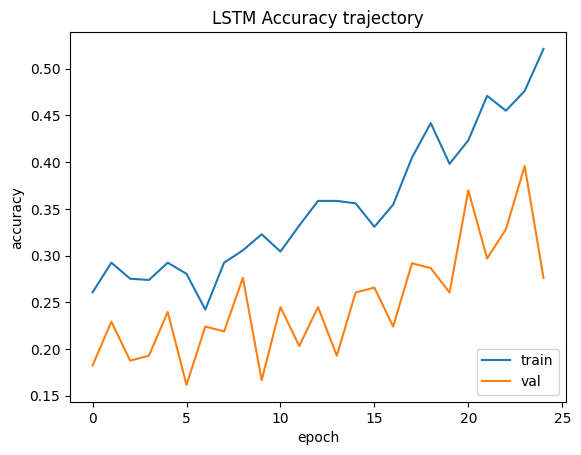

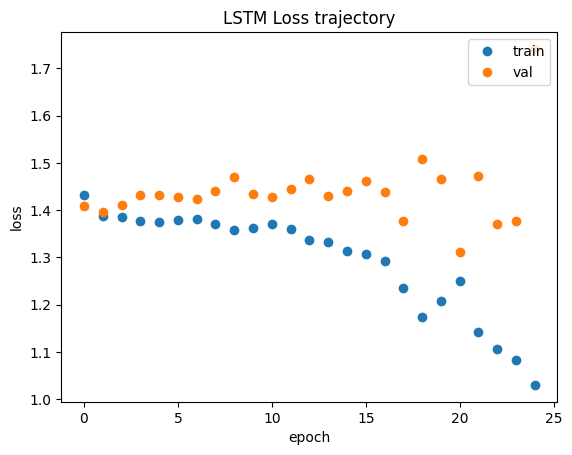

Test accuracy for Subject 1: 0.30000001192092896


In [ ]:
plotAccuracyLossHistory(history, 'Training of LSTM model on subject 1 data')
# Evaluating on test set
score = lstm_model.evaluate(X_test1, y_test1, verbose=0)
print('Test accuracy for Subject 1:', score[1])

In [ ]:
lstm_model.save('final1vs1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Training on all Subjects and Testing on Subject 1

In [ ]:
lstm_model_all1 = lstm_model_definition(dropout=0.01)

# Compile the model
optimizer = Adam(learning_rate=0.01)
lstm_model_all1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Train the model on all data
history_all_data = lstm_model_all1.fit(x=train_TF, validation_data = valid_TF, epochs=25, batch_size=32, verbose=True)

Epoch 1/25
212/212 [==============================] - 42s 154ms/step - loss: 1.4013 - accuracy: 0.2533 - val_loss: 1.4043 - val_accuracy: 0.2364
Epoch 2/25
212/212 [==============================] - 27s 127ms/step - loss: 1.3878 - accuracy: 0.2509 - val_loss: 1.4035 - val_accuracy: 0.2270
Epoch 3/25
212/212 [==============================] - 26s 120ms/step - loss: 1.3883 - accuracy: 0.2519 - val_loss: 1.4071 - val_accuracy: 0.2364
Epoch 4/25
212/212 [==============================] - 25s 120ms/step - loss: 1.3885 - accuracy: 0.2499 - val_loss: 1.3891 - val_accuracy: 0.2506
Epoch 5/25
212/212 [==============================] - 26s 122ms/step - loss: 1.3882 - accuracy: 0.2460 - val_loss: 1.3973 - val_accuracy: 0.2506
Epoch 6/25
212/212 [==============================] - 26s 121ms/step - loss: 1.3871 - accuracy: 0.2497 - val_loss: 1.3891 - val_accuracy: 0.2364
Epoch 7/25
212/212 [==============================] - 26s 122ms/step - loss: 1.3864 - accuracy: 0.2465 - val_loss: 1.3914 - val_ac

In [ ]:
lstm_model.save('finalall.h5')

Training of LSTM model on all data



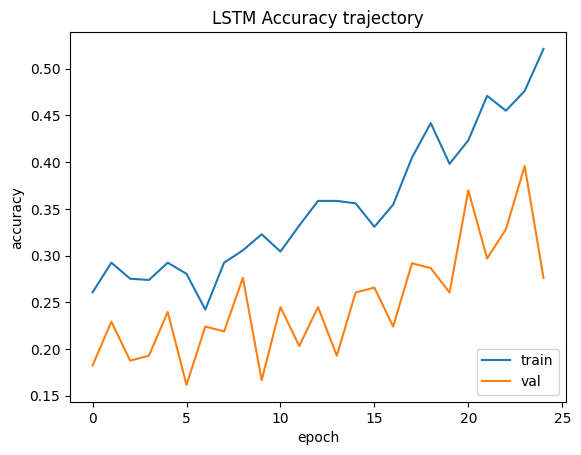

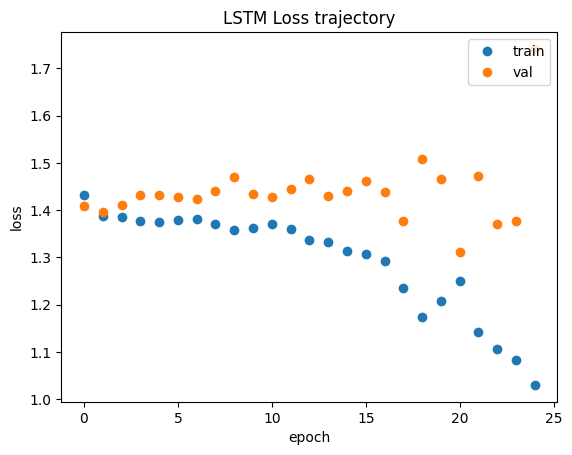

Test accuracy for Subject 1: 0.30000001192092896


In [ ]:
plotAccuracyLossHistory(history, 'Training of LSTM model on all data')
# Evaluating on test set
score_subject1 = lstm_model.evaluate(X_test1, y_test1, verbose=0)
print('Test accuracy for Subject 1:', score_subject1[1])

# Training on all data and testing on all data

Training of LSTM model on all data



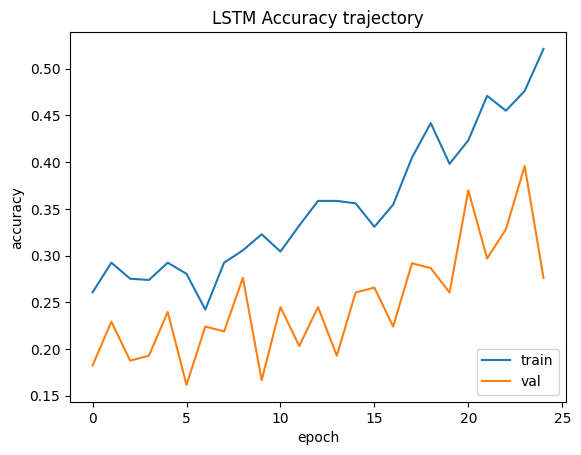

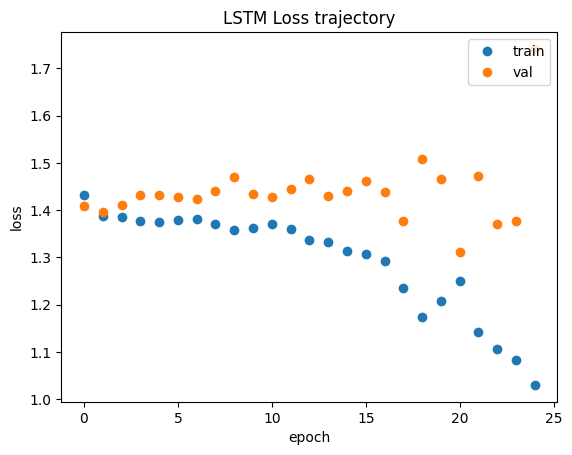

Test accuracy: 0.2708803713321686


In [ ]:
plotAccuracyLossHistory(history, 'Training of LSTM model on all data')
# Evaluating on test set
score_subject_all = lstm_model.evaluate(test_TF, verbose=0)
print('Test accuracy:', score_subject_all[1])

In [ ]:
lstm_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (None, 400, 512)          1095680   
                                                                 
 lstm_137 (LSTM)             (None, 400, 256)          787456    
                                                                 
 lstm_138 (LSTM)             (None, 400, 128)          197120    
                                                                 
 lstm_139 (LSTM)             (None, 64)                49408     
                                                                 
 dense_36 (Dense)            (None, 4)                 260       
                                                                 
Total params: 2129924 (8.13 MB)
Trainable params: 2129924 (8.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Evaluating classification accuracy as a function of time

In [ ]:
# Helper function to generate crops of data in time series
def generateCroppedDataSet(train_x, valid_x, test_x, begin, end):
  c_tr_x = train_x[:, begin:end, :]
  c_v_x = valid_x[:, begin:end, :]
  c_te_x = test_x[:, begin:end, :]
  return c_tr_x, c_v_x, c_te_x

In [ ]:
def generateTensors(train, valid, test):
  # construct the dataset from the NumPy arrays
  train = tf.data.Dataset.from_tensor_slices((train, y_train))
  valid = tf.data.Dataset.from_tensor_slices((valid, y_valid))
  test = tf.data.Dataset.from_tensor_slices((test, y_test))

  # batch and shuffle
  train = train.shuffle(1024).batch(32)
  valid = valid.shuffle(1024).batch(32)
  test = test.shuffle(1024).batch(32)

  return train, valid, test

# Generating Results for Different Time Frames

*   0 - 100
*   0 - 200
*   0 - 300
*   0 - 400





Analyzing the frame (0, 100)
(6768, 100, 22) (1692, 100, 22) (443, 100, 22)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 512)          1095680   
                                                                 
 lstm_9 (LSTM)               (None, 100, 256)          787456    
                                                                 
 lstm_10 (LSTM)              (None, 100, 128)          197120    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2129924 (8.13 MB)
Trainable params: 2129924 (8.13 MB)
Non-trainable params: 0 (0.00 Byte)
______

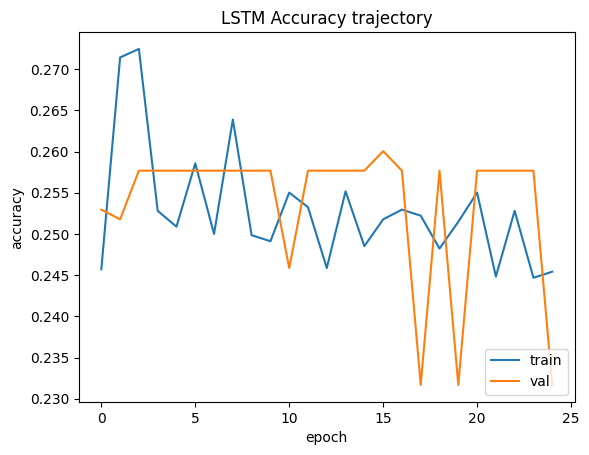

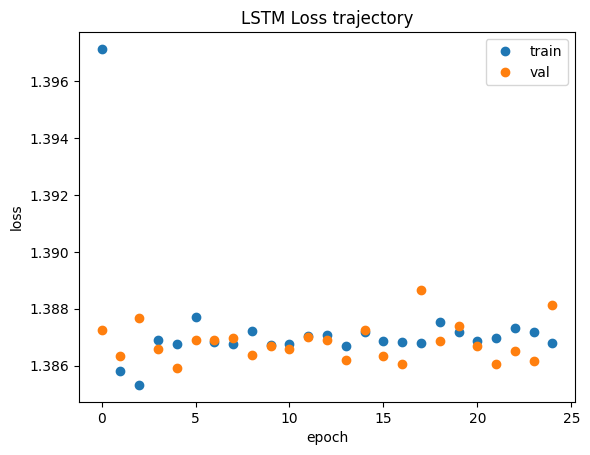

Test accuracy of model: 0.2505643367767334


Analyzing the frame (0, 200)
(6768, 200, 22) (1692, 200, 22) (443, 200, 22)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200, 512)          1095680   
                                                                 
 lstm_13 (LSTM)              (None, 200, 256)          787456    
                                                                 
 lstm_14 (LSTM)              (None, 200, 128)          197120    
                                                                 
 lstm_15 (LSTM)              (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2129924 (8.13 MB)
Trainable params: 2129924 (8.13 M

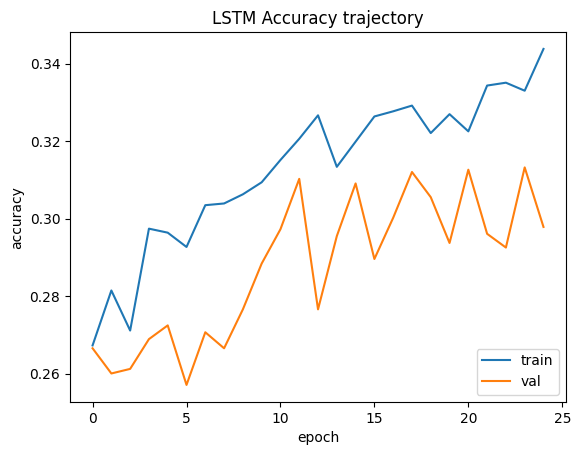

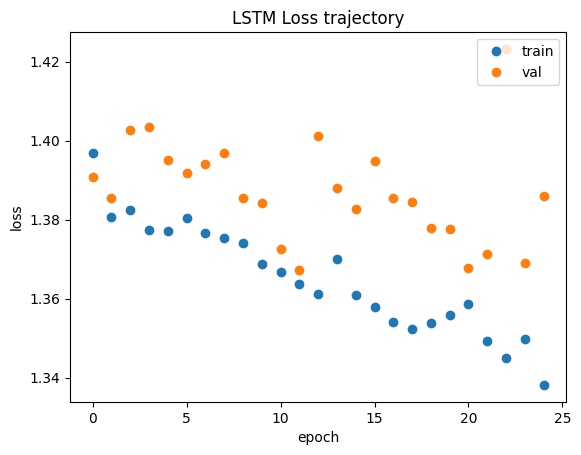

Test accuracy of model: 0.2618510127067566


Analyzing the frame (0, 300)
(6768, 300, 22) (1692, 300, 22) (443, 300, 22)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 300, 512)          1095680   
                                                                 
 lstm_17 (LSTM)              (None, 300, 256)          787456    
                                                                 
 lstm_18 (LSTM)              (None, 300, 128)          197120    
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2129924 (8.13 MB)
Trainable params: 2129924 (8.13 M

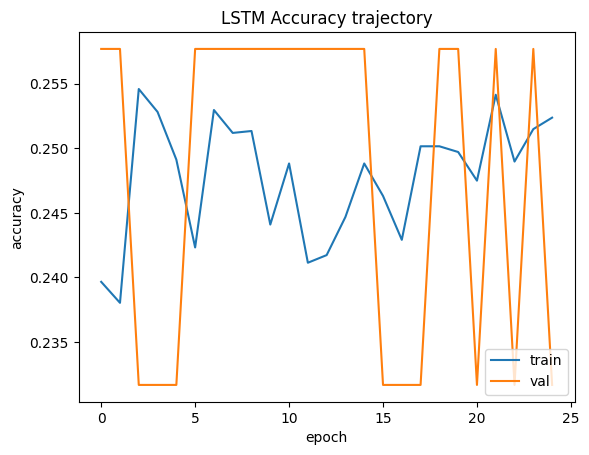

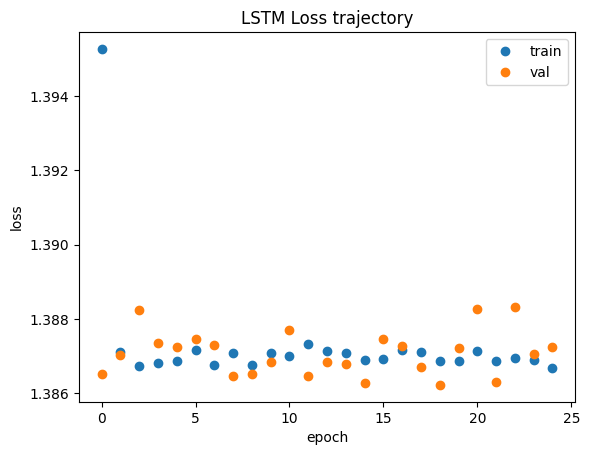

Test accuracy of model: 0.2505643367767334


Analyzing the frame (0, 400)
(6768, 400, 22) (1692, 400, 22) (443, 400, 22)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 400, 512)          1095680   
                                                                 
 lstm_21 (LSTM)              (None, 400, 256)          787456    
                                                                 
 lstm_22 (LSTM)              (None, 400, 128)          197120    
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2129924 (8.13 MB)
Trainable params: 2129924 (8.13 M

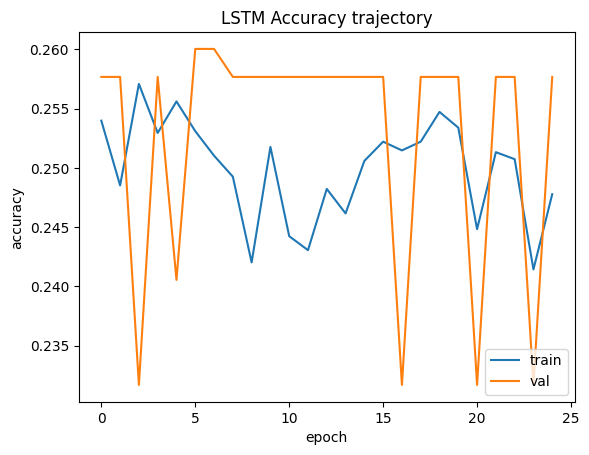

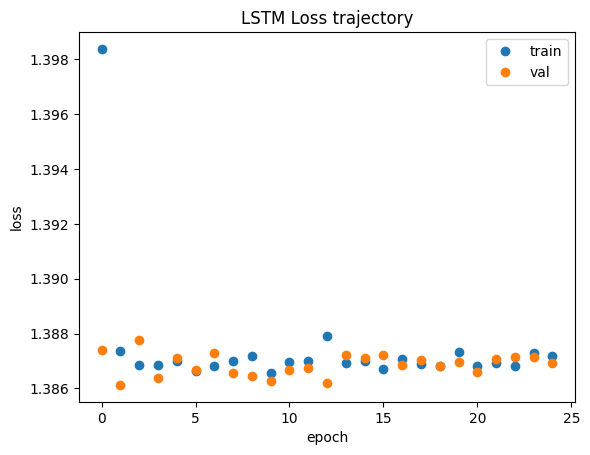

Test accuracy of model: 0.21670429408550262




In [ ]:
test_acc = []
for end in [100, 200, 300, 400]:
  time_frame = (0, end)
  print('Analyzing the frame', time_frame)
  c_tr_x, c_v_x, c_te_x = generateCroppedDataSet(X_train, X_valid, X_test, 0, end)
  print(c_tr_x.shape, c_v_x.shape, c_te_x.shape)
  train, valid, test = generateTensors(c_tr_x, c_v_x, c_te_x)
  # We have data now, so we need to train a model
  c_model = lstm_model_definition(dropout=0.01, input_shape=(c_tr_x.shape[1], c_tr_x.shape[2]))
  c_model.summary()
  c_model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
  c_model_results = c_model.fit(x=train, validation_data=valid, epochs=25, verbose=True)
  plotAccuracyLossHistory(c_model_results, 'Model Training')
  score = c_model.evaluate(x=test, verbose=0)
  print('Test accuracy of model:', score[1])
  test_acc.append(score[1])
  print()
  print()

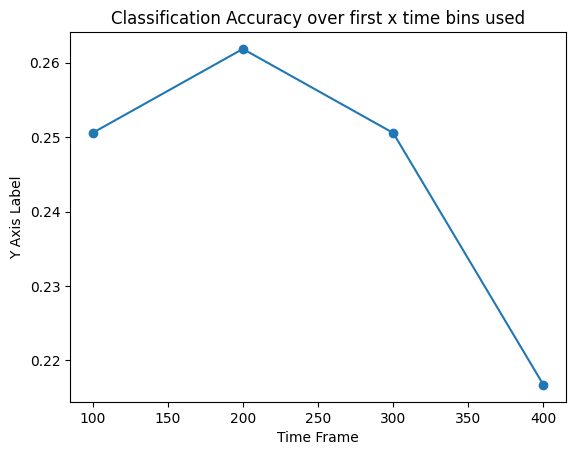

In [ ]:
x_values = [100, 200, 300, 400]
plt.plot(x_values, test_acc, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Time Frame')
plt.ylabel('Y Axis Label')
plt.title('Classification Accuracy over first x time bins used')

# Show plot
plt.show()